## 遗传算法求解一元函数区间内最大值

In [1]:
# 导包

#jupyter matplotlib内置绘图的魔术命令
%matplotlib inline
#matplotlib绘图、3D相关包
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

#运算、操作处理相关包
import numpy as np
import pandas as pd

In [8]:
class GA():

    # input:
    #     nums: m * n  n is nums_of x, y, z, ...,and m is population's quantity
    #     bound:n * 2  [(min, nax), (min, max), (min, max),...]
    #     DNA_SIZE is binary bit size, None is auto
    def __init__(self, nums, bound, func, DNA_SIZE=None, cross_rate=0.8, mutation=0.003):
        nums = np.array(nums)
        bound = np.array(bound)
        self.bound = bound
        if nums.shape[1] != bound.shape[0]:
            raise Exception(f'范围的数量与变量的数量不一致, 您有{nums.shape[1]}个变量，却有{bound.shape[0]}个范围')

        for var in nums:
            for index, var_curr in enumerate(var):
                if var_curr < bound[index][0] or var_curr > bound[index][1]:
                    raise Exception(f'{var_curr}不在取值范围内')

        for min_bound, max_bound in bound:
            if max_bound < min_bound:
                raise Exception(f'抱歉，({min_bound}, {max_bound})不是合格的取值范围')

        #所有变量的最小值和最大值
        #var_len为所有变量的取值范围大小
        #bit为每个变量按整数编码最小的二进制位数
        min_nums, max_nums = np.array(list(zip(*bound)))
        self.var_len = var_len = max_nums-min_nums
        bits = np.ceil(np.log2(var_len+1))

        if DNA_SIZE == None:
            DNA_SIZE = int(np.max(bits))
        self.DNA_SIZE = DNA_SIZE

        #POP_SIZE为进化的种群数
        self.POP_SIZE = len(nums)
        POP = np.zeros((*nums.shape, DNA_SIZE))
        for i in range(nums.shape[0]):
            for j in range(nums.shape[1]):
        #编码方式：
                num = int(round((nums[i,j] - bound[j][0]) * ((2**DNA_SIZE) / var_len[j])))
        #用python自带的格式化转化为前面空0的二进制字符串，然后拆分成列表
                POP[i,j] = [int(k) for k in ('{0:0'+str(DNA_SIZE)+'b}').format(num)]
        self.POP = POP
        #用于后面重置（reset）
        self.copy_POP = POP.copy()
        self.cross_rate = cross_rate
        self.mutation = mutation
        self.func = func

    #save args对象保留参数：
    #        bound                取值范围
    #        var_len              取值范围大小
    #        POP_SIZE             种群大小
    #        POP                  编码后的种群[[[1,0,1,...],[1,1,0,...],...]]
    #                             一维元素是各个种群，二维元素是各个DNA[1,0,1,0]，三维元素是碱基对1/0
    #        copy_POP             复制的种群，用于重置
    #        cross_rate           染色体交换概率
    #        mutation             基因突变概率
    #        func                 适应度函数
    #将编码后的DNA翻译回来（解码）
    
    
    def translateDNA(self):
        W_vector = np.array([2**i for i in range(self.DNA_SIZE)]).reshape((self.DNA_SIZE, 1))[::-1]
        binary_vector = self.POP.dot(W_vector).reshape(self.POP.shape[0:2])
        for i in range(binary_vector.shape[0]):
            for j in range(binary_vector.shape[1]):
                binary_vector[i, j] /= ((2**self.DNA_SIZE)/self.var_len[j])
                binary_vector[i, j] += self.bound[j][0]
        return binary_vector


    def get_fitness(self, non_negative=False):
        result = self.func(*np.array(list(zip(*self.translateDNA()))))
        if non_negative:
            min_fit = np.min(result, axis=0)
#             result -= min_fit 
            result = result - min_fit +1e-3
        return result
    
#自然选择
    def select(self):
        fitness = self.get_fitness(non_negative=True)
        self.POP = self.POP[np.random.choice(np.arange(self.POP.shape[0]), size=self.POP.shape[0], replace=True, p=fitness/np.sum(fitness))]

#染色体交叉
    def crossover(self):
        for people in self.POP:
            if np.random.rand() < self.cross_rate:
                i_ = np.random.randint(0, self.POP.shape[0], size=1)
                cross_points = np.random.randint(0, 2, size=(len(self.var_len) ,self.DNA_SIZE)).astype(np.bool) 
                people[cross_points] = self.POP[i_, cross_points]

#基因变异
    def mutate(self):
        for people in self.POP:
            for var in people:
                for point in range(self.DNA_SIZE):
                    if np.random.rand() < self.mutation:
                        var[point] = 1 if var[point] == 0 else 1
    
#进化
    def evolution(self):
        self.select()
        self.crossover()
        self.mutate()
        
        
#重置
    def reset(self):
        self.POP = self.copy_POP.copy()
    
#打印当前状态日志
    def log(self):
        return pd.DataFrame(np.hstack((self.translateDNA(), self.get_fitness().reshape((len(self.POP),1)))), 
                            columns=[f'x{i}' for i in range(len(self.var_len))]+['F'])
#一维变量作图
    def plot_in_jupyter_1d(self, iter_time=200):
        for _ in range(iter_time):
            self.evolution()

        fig, ax = plt.subplots()

        x = np.linspace(*self.bound[0], self.var_len[0]*50)
        ax.plot(x, self.func(x))

        x = self.translateDNA().reshape(self.POP_SIZE)
        ax.scatter(x, self.func(x), s=200, lw=0, c='red', alpha=0.5)
        fig.show()

<ipython-input-8-4d889348ab9c>:91: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cross_points = np.random.randint(0, 2, size=(len(self.var_len) ,self.DNA_SIZE)).astype(np.bool)
<ipython-input-8-4d889348ab9c>:129: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


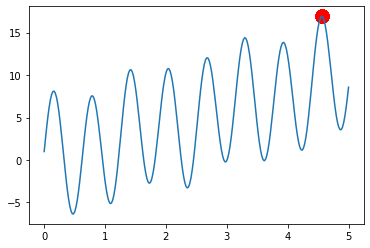

In [9]:
func = lambda x:2*x+7*np.sin(10*x) + np.cos(4*x)
ga = GA([[np.random.rand()*5] for _ in range(100)], [(0,5)], DNA_SIZE=10, func=func)
ga.plot_in_jupyter_1d()